In [1]:
%matplotlib inline

In [2]:
# Create your first MLP in Keras
from keras import optimizers, initializers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import re
import matplotlib as mpl
import numpy as np
import pandas as pd

plt.rcParams.update({
    'figure.figsize': (9, 6),
    'font.family': 'serif',
    'font.size': 16
})

Using TensorFlow backend.


In [3]:
# fix random seed for reproducibility
np.random.seed(7)

In [4]:
def verify_measured_format(dataset):
    good = True
    good &= all([(k in dataset) for k in
                 ("Meas-GS-A",
                  "Meas-GS-B",
                  "Meas-FvA",
                  "Meas X",
                  "Meas Y",
                  "Meas Z",
                  "Meas YS")])
    return good

def remap_measured_column_names(dataset):
    rename = {
        "Meas-GS-A": "Grain size, A (um)",
        "Meas-GS-B": "Grain size, B (um)",
        "Meas-FvA": "Volume fraction A",
        "Meas X": "Solute concentration, X (ppm)",
        "Meas Y": "Solute concentration, Y (ppm)",
        "Meas Z": "Solute concentration, Z (ppm)",
        "Meas YS": "Yield strength (MPa)"
    }
    columns = list(dataset.columns)
    try:
        newcolumns = [rename[k] for k in rename]
    except KeyError:
        raise KeyError("Unrecognized column names cannot be remapped.")
    dataset.columns = newcolumns
    
def verify_modeled_format(dataset):
    good = True
    good &= all([(k in dataset) for k in
                 ("GS-A (um)",
                  "GS-B (um)",
                  "Fv-A",
                  "Solute X in A",
                  "Solute Y in A",
                  "Solute Z in B",
                  "YS (MPa)")])
    return good

def remap_modeled_column_names(dataset):
    rename = {
        "GS-A (um)": "Grain size, A (um)",
        "GS-B (um)": "Grain size, B (um)",
        "Fv-A": "Volume fraction A",
        "Solute X in A": "Solute concentration, X (ppm)",
        "Solute Y in A": "Solute concentration, Y (ppm)",
        "Solute Z in B": "Solute concentration, Z (ppm)",
        "YS (MPa)": "Yield strength (MPa)"
    }
    columns = list(dataset.columns)
    try:
        newcolumns = [rename[k] for k in rename]
    except KeyError:
        raise KeyError("Unrecognized column names cannot be remapped.")
    dataset.columns = newcolumns

In [5]:
# load the yield strength data set
# dataset = pd.read_excel("../data/Database 1 for new NN-poly test.xlsx",
#                         sheet_name="YS Model",
#                         skiprows=1,
#                         usecols='I:O')
dataset = pd.read_excel("data/Database 1 for new NN-poly test.xlsx",
                        sheet_name="Extended YS Model",
                        skiprows=1,
                        usecols='B:H')

# verify data format
verify_modeled_format(dataset)

# remap column names
remap_modeled_column_names(dataset)

# split into input (X) and output (Y) variables
feature_names = ["Grain size, A (um)",
                 "Grain size, B (um)",
                 "Volume fraction A",
                 "Solute concentration, X (ppm)",
                 "Solute concentration, Y (ppm)",
                 "Solute concentration, Z (ppm)"]
target_name = "Yield strength (MPa)"
X = dataset.loc[:, feature_names].values
Y = dataset.loc[:, target_name].values[:, np.newaxis]
scaler = StandardScaler()
scaler.fit(X);

In [6]:
print(f"Dataset shape: {dataset.shape}")
dataset.describe()

Dataset shape: (3168, 7)


,"Grain size, A (um)","Grain size, B (um)",Volume fraction A,"Solute concentration, X (ppm)","Solute concentration, Y (ppm)","Solute concentration, Z (ppm)",Yield strength (MPa)
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,14.363005,22.841540,0.751840,7.970644,7.029356,0.754223,641.940888
std,6.329011,12.980621,0.117842,4.295020,4.295020,0.147293,128.331820
min,4.000000,1.000000,0.550000,1.000000,0.000000,0.500000,348.918388
25%,9.000000,11.000000,0.650000,4.000000,3.000000,0.630000,547.103640
50%,14.000000,23.000000,0.760000,8.000000,7.000000,0.760000,645.323020
75%,20.000000,34.000000,0.850000,12.000000,11.000000,0.880000,738.808673
max,25.000000,45.000000,0.950000,15.000000,14.000000,1.000000,916.505787


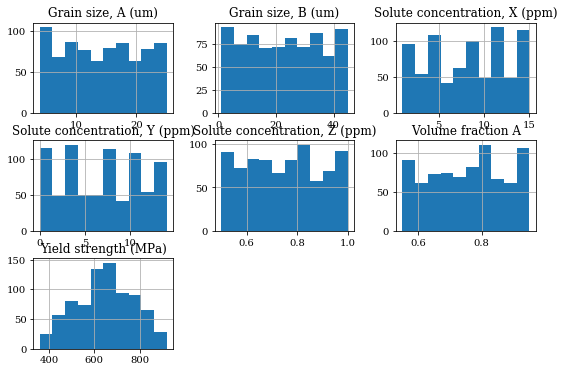

In [25]:
fig = dataset.hist(figsize=(9, 6));
[x.title.set_size(12) for x in fig.ravel()];
[x.tick_params(labelsize=10) for x in fig.ravel()];

In [128]:
# create model
def baseline_model():
    hidden_units = 16
    opts = {
        'activation': 'relu',
        'kernel_initializer': 'normal',
        'use_bias': True
    }
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=6, **opts))
    model.add(Dense(hidden_units, **opts))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse', 'mae', 'mape'])
    return model

# Use the KerasRegressor wrapper
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(baseline_model,
                                         epochs=100,
                                         batch_size=5,
                                         verbose=0)))
pipeline = Pipeline(estimators)
kf = KFold(n_splits=5, random_state=7)
results = cross_val_score(pipeline, X, Y, cv=kf)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

history = pipeline.fit(X, Y)

Results: -980.46 (105.34) MSE


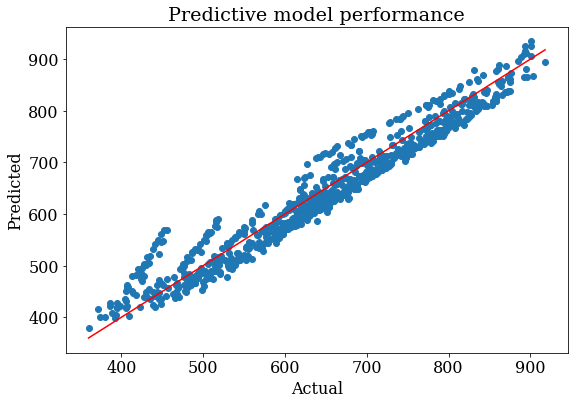

In [129]:
# Plot predicted vs. actual
plt.figure()
yactual = Y.ravel()
ypred = pipeline.predict(X).ravel()
lo = min(np.min(yactual), np.min(ypred))
hi = max(np.max(yactual), np.max(yactual))
plt.scatter(Y.ravel(), ypred)
plt.plot([lo, hi], [lo, hi], 'r-')
plt.title("Predictive model performance")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [130]:
weights = pipeline.get_params()['mlp'].model.get_weights()
[wts.shape for wts in weights]

[(6, 16), (16,), (16, 16), (16,), (16, 1), (1,)]

In [133]:
weights[1]

array([1.555094 , 1.8752394, 1.6786125, 1.6531521, 1.6923159, 1.5776169,
       1.6928694, 1.6467534, 1.7895095, 1.6431001, 1.7103826, 1.6741103,
       1.7381296, 1.269688 , 1.6464734, 1.6222416], dtype=float32)